# **Flood Prediction Using High-Resolution Multispectral Drone Imagery**  

## **Overview**  
Flooding is a major environmental and socio-economic challenge, often exacerbated by rapid urbanization and poor drainage planning. This project aims to predict flood-prone areas using **very high-resolution multispectral drone imagery** captured outside the rainy season. The analysis integrates **Digital Terrain Model (DTM)** to understand terrain characteristics and improve flood prediction accuracy.  

- **Machine Learning Models** will be applied to predict flood-prone areas based on:  
  - Elevation and slope data  
  - Land cover classification  
  - Distance to key features (roads, water, urban areas)

## **Data Acquisition and Processing**  

1. **Multispectral Drone Imagery**  
   - High-resolution images captured at the **centimeter-level** provide detailed land cover information.  
   - The imagery is collected outside the rainy season to ensure a clear view of ground features without water interference.  

2. **Elevation Data**  
   - **DTM** (Digital Terrain Model): Represents the bare-earth surface, providing information on natural terrain elevation.  
   - **DSM** (Digital Surface Model): Includes all features on the surface, such as buildings and trees, helping differentiate land cover types.  

## **Feature Engineering**  

To enhance the predictive power of our flood models, we will derive several features from the available data:  

1. **Terrain Analysis**  
   - **Slope**: Measures the steepness of the terrain, as steeper areas are less prone to flooding.  
   - **Elevation differences (DTM vs. DSM)**: Helps distinguish between low-lying and elevated regions.  

2. **Distance-Based Features**  
   - **Distance to roads** (both **tiled** and **untiled**): Proximity to roads can influence water runoff patterns.  
   - **Distance to open water**: Determines the likelihood of flooding based on proximity to permanent water bodies.  
   - **Distance to urban areas**: Urbanization affects drainage patterns and flood susceptibility.  

3. **Land Cover Classification**  
   - The multispectral imagery will be classified into different land cover types, which will serve as important predictors for flooding.  

## **Data Labeling and Model Training**  

1. **Training and Test Data Selection**  
   - We will **leverage local knowledge** to label areas as **flooded or non-flooded** based on historical observations.  
   - This labeled dataset will be used to train and evaluate the models.  

2. **Integration of Image Classification Results**  
   - The classified land cover map will be **incorporated as a feature** in the flood prediction model.  
   - This helps capture the impact of different land cover types on flooding, e.g., **bare land and low-lying areas are more prone to flooding, while dense vegetation can help absorb water**.  


## **Expected Outcomes**  

1. **A Flood Susceptibility Map**  
   - Identifies areas at high risk of flooding based on the terrain, land cover, and spatial relationships with key features.  

2. **Data-Driven Insights for Flood Mitigation**  
   - Helps urban planners and disaster management agencies make informed decisions about flood prevention and response.  

3. **Scalable Model for Other Locations**  
   - The methodology can be adapted for other regions using similar datasets, enabling broader flood risk assessment applications.  

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import glob
from rasterio.plot import reshape_as_image

# import arcpy
# from arcpy.sa import *
# from arcpy.ia import *
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from osgeo import gdal, ogr
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, ConfusionMatrixDisplay, confusion_matrix,
                            classification_report)

from shapely.geometry import Polygon, MultiPolygon

### Folder Structure
```
C:/Users/Admin/Desktop/geoai_flood_prediction/
│
├── data/
│   ├── OIL_MILL_AXIS/
│   │   ├── SOBAZ_OILMILL_EXTENSIVE_ORTHOPHOTO.tif
│   │   ├── SOBAZ_OILMILL_EXTENSIVE_DTM.tif
│   │   ├── SOBAZ_OILMILL_EXTENSIVE_DSM.tif
│   │   ├── OIL_MILL_AXIS.shp
│   │   ├── other_data/
│   │   │   ├── open_water.shp
│   │   │   ├── tarred_road.shp
│   │   │   ├── untarred_road.shp
│   │   ├── input/
│   │   │   ├── red.tif
│   │   │   ├── green.tif
│   │   │   ├── blue.tif
│   │   │   ├── dtm.tif
│   │   │   ├── dsm.tif
│   │   ├── resampled_data/
│   │   │   ├── resampled_rgb.tif
│   │   │   ├── resampled_dtm.tif
│   │   │   ├── resampled_dsm.tif
│   │   ├── mask/
│   │   ├── prediction_points/
│   │       ├── predicitve_points.shp
│   │   ├── sampling_points/
│   │   │   ├── sampling_points.shp
│   │   │   ├── sampling_points.dbf
│   │   │   ├── sampling_points.shx
│
├── C:/Windows/Temp/
│   ├── resampled_rgb.tif
```

## Set Environments

In [2]:
# Set working directory
WORK_DIR = r"C:/Users/Admin/Desktop/geoai_flood_prediction"
DATA_FOLDER = "data/PH_METRO/TRAIN"

# Input raster files
RGB_IMAGE = "RESAMPLED_ORHTOPHOTO/PH_METRO_ORTHOPOHTO.tif"
DTM_IMAGE = "RESAMPLED_DTM/PH_METRO_DTM.tif"
DSM_IMAGE = "RESAMPLED_DSM/PH_METRO_DSM.tif"
BOUNDARY = "PH_TRAIN_BOUND.shp"

# set the resampling scell size to any size you want
RESAMPLING_CELL_SIZE = 2


# Define folder names
TEMP_DIR = r"C:/Windows/Temp"
OTHER_DATA_FOLDER = "other_data"
INPUT_FOLDER = "input"
RESAMPLE_FOLDER = "resampled_data"
MASK_FOLDER = "mask"
PREDICTIVE_POINT_FOLDER = "prediction_points"
SAMPLING_POINT_FOLDER = "sampling_points"

# Additional datasets
OPEN_WATER = "open_water.shp"
TARRED_ROAD = "tarred_road.shp"
UNTARRED_ROAD = "untarred_road.shp"
FLOOD_PREDICTIVE_POINT = "predictive_points.shp"
FLOOD_PREDICTIVE_PAQ_POINT = "predictive_points.parquet"
FLOOD_SAMPLING_POINT = "sampling_points.shp"

# Construct full paths
DATA_DIR = os.path.join(WORK_DIR, DATA_FOLDER)
OTHER_DATA_DIR = os.path.join(DATA_DIR, OTHER_DATA_FOLDER)
INPUT_DIR = os.path.join(DATA_DIR, INPUT_FOLDER)
RESAMPLED_DIR = os.path.join(DATA_DIR, RESAMPLE_FOLDER)
MASKED_DIR = os.path.join(DATA_DIR, MASK_FOLDER)
PREDICTIVE_POINT_DIR = os.path.join(DATA_DIR, PREDICTIVE_POINT_FOLDER)
SAMPLING_POINT_DIR = os.path.join(DATA_DIR, SAMPLING_POINT_FOLDER)

# Ensure directories exist (without creating them)
required_dirs = [
    WORK_DIR, DATA_DIR, OTHER_DATA_DIR, INPUT_DIR, 
    RESAMPLED_DIR, MASKED_DIR, PREDICTIVE_POINT_DIR, SAMPLING_POINT_DIR
]

for directory in required_dirs:
    if not os.path.exists(directory):
        print(f"Warning: Directory {directory} does not exist!")
        os.mkdir(directory)
        

# Paths to input files
RGB_PATH = os.path.join(DATA_DIR, RGB_IMAGE)
DTM_PATH = os.path.join(DATA_DIR, DTM_IMAGE)
DSM_PATH = os.path.join(DATA_DIR, DSM_IMAGE)
BOUNDARY_PATH = os.path.join(DATA_DIR, BOUNDARY)

# Paths to additional datasets
OPEN_WATER_PATH = os.path.join(OTHER_DATA_DIR, OPEN_WATER)
TARRED_ROAD_PATH = os.path.join(OTHER_DATA_DIR, TARRED_ROAD)
UNTARRED_ROAD_PATH = os.path.join(OTHER_DATA_DIR, UNTARRED_ROAD)
FLOOD_PREDICTIVE_PATH = os.path.join(PREDICTIVE_POINT_DIR, FLOOD_PREDICTIVE_POINT)
FLOOD_PREDICTIVE_PAQ_PATH = os.path.join(PREDICTIVE_POINT_DIR, FLOOD_PREDICTIVE_PAQ_POINT)
FLOOD_SAMPLING_PATH = os.path.join(SAMPLING_POINT_DIR, FLOOD_SAMPLING_POINT)

# Resampling output file paths
TEMP_RGB_PATH = os.path.join(TEMP_DIR, "resampled_rgb.tif")
RESAMPLED_RGB_PATH = os.path.join(RESAMPLED_DIR, "resampled_rgb.tif")
RESAMPLED_DTM_PATH = os.path.join(RESAMPLED_DIR, "resampled_dtm.tif")
RESAMPLED_DSM_PATH = os.path.join(RESAMPLED_DIR, "resampled_dsm.tif")

# Output file paths
OUTPUT_RED_PATH = os.path.join(INPUT_DIR, 'red.tif')
OUTPUT_GREEN_PATH = os.path.join(INPUT_DIR, 'green.tif')
OUTPUT_BLUE_PATH = os.path.join(INPUT_DIR, 'blue.tif')
OUTPUT_DTM_PATH = os.path.join(INPUT_DIR, 'dtm.tif')
OUTPUT_DSM_PATH = os.path.join(INPUT_DIR, 'dsm.tif')

# Ensure necessary files exist
required_files = [
    RGB_PATH, DTM_PATH, DSM_PATH, BOUNDARY_PATH,
    OPEN_WATER_PATH, TARRED_ROAD_PATH, UNTARRED_ROAD_PATH,
    FLOOD_PREDICTIVE_PATH, FLOOD_PREDICTIVE_PAQ_PATH, FLOOD_SAMPLING_PATH
]

for file_path in required_files:
    if not os.path.exists(file_path):
        print(f"Warning: {file_path} does not exist!")

In [3]:
# def export_array_to_image(src_image, image_array, new_image, nodata_value=np.nan):
#     """Export the array file to a raster image with NoData set for a white background."""
#     try:
#         with rasterio.open(src_image) as src_img:
#             profile = src_img.profile  # Get the profile of the reference image

#             # Update the profile of the new data
#             profile.update(count=3, dtype=image_array.dtype, nodata=nodata_value)

#             # Convert nodata areas to np.nan
#             image_array = np.where(image_array <= 0.000001, np.nan, image_array)

#             # Write the new image
#             with rasterio.open(new_image, "w", **profile) as dst:
#                 data = reshape_as_image(image_array)
#                 dst.write(reshape_as_image(data))

#             print("Image arrary generate Generated Successfully")
#     except Exception as e:
#         print(f"An Error Occurred: {e}")

In [4]:
# Set ArcPy analysis environment
arcpy.env.workspace = DATA_DIR
arcpy.env.overwriteOutput = True
# arcpy.env.extent = BOUNDARY_PATH
# arcpy.env.mask = BOUNDARY_PATH

NameError: name 'arcpy' is not defined

### Load and Resample all Raster Datasets

In [5]:
# def load_image(image_path, data_format="GTiff"):
#     """Load imagery using GDAL."""
#     if not os.path.exists(image_path):
#         print("Image not available")
#         return None  
    
#     try:
#         driver = gdal.GetDriverByName(data_format)
#         driver.Register()
#         raster_image = gdal.Open(image_path)  # Open image with GDAL
        
#         if raster_image is None:
#             print("Failed to load image")
#             return None
#         return raster_image
#     except Exception as e:
#         print(f"An error occurred: {e}")
#         return None

# def resample_image(image, x_resolution, y_resolution, output_path):
#     """Resample raster data using bilinear interpolation, excluding NoData and background values."""
    
#     gdal_raster = load_image(image)
    
#     if gdal_raster is None:
#         raise ValueError("Invalid input image. Make sure the image is loaded correctly.")

#     # Set NoData value explicitly and apply masking
#     resampled_image = gdal.Warp(
#         output_path,
#         gdal_raster,
#         xRes=x_resolution,
#         yRes=y_resolution,
#         resampleAlg=gdal.GRA_Bilinear,
#     )

#     if resampled_image is None:
#         raise RuntimeError("Resampling failed. Check input parameters.")

#     resampled_image = None  # Ensure proper cleanup

#     return output_path

### Resample and Copy Data from the RGB,DSM and DTM to the output data as they are one of the feature for prediction of flooding

In [6]:
# # Resample RGB, DTM, and DSM images
# # resampled_rgb_path = resample_image(image=RGB_PATH, x_resolution=RESAMPLING_CELL_SIZE,
# #                                     y_resolution=RESAMPLING_CELL_SIZE, output_path=TEMP_RGB_PATH )
# # resampled_dtm_path = resample_image(image=DTM_PATH, x_resolution=RESAMPLING_CELL_SIZE,
# #                                     y_resolution=RESAMPLING_CELL_SIZE, output_path=RESAMPLED_DTM_PATH)
# # resampled_dsm_path = resample_image(image=DSM_PATH, x_resolution=0.2, y_resolution=0.2, output_path=RESAMPLED_DSM_PATH)

# # Cop RGB Bands
# arcpy.management.CopyRaster(
#     in_raster=os.path.join(resampled_rgb_path),
#     out_rasterdataset=RESAMPLED_RGB_PATH,
#     background_value=None,
#     nodata_value="0",
#     format="TIFF"
# )


# # Copy RGB bands separately
# arcpy.management.CopyRaster(
#     in_raster=os.path.join(resampled_rgb_path, 'Band_1'),
#     out_rasterdataset=OUTPUT_RED_PATH,
#     background_value=None,
#     nodata_value="0",
#     format="TIFF"
# )

# arcpy.management.CopyRaster(
#     in_raster=os.path.join(resampled_rgb_path, 'Band_2'),
#     out_rasterdataset=OUTPUT_GREEN_PATH,
#     background_value=None,
#     nodata_value="0",
#     format="TIFF"
# )

# arcpy.management.CopyRaster(
#     in_raster=os.path.join(resampled_rgb_path, 'Band_3'),
#     out_rasterdataset=OUTPUT_BLUE_PATH,
#     background_value=None,
#     nodata_value="0",
#     format="TIFF"
# )

# # Copy DTM to output folder
# arcpy.management.CopyRaster(
#     in_raster=resampled_dtm_path,
#     out_rasterdataset=OUTPUT_DTM_PATH,
#     background_value=None,
#     nodata_value="0",
#     format="TIFF"
# )

# # Copy DSM to output folder
# # arcpy.management.CopyRaster(
# #     in_raster=resampled_dsm_path,
# #     out_rasterdataset=OUTPUT_DSM_PATH,
# #     background_value=None,
# #     nodata_value="0",
# #     format="TIFF"
# # )TPUT_DSM_PATH)


### **Feature Engineering for Flood Prediction**  

### **1. Introduction**
#### **What is Feature Engineering?**
Feature engineering is the process of selecting, transforming, and creating new variables (features) from raw data to improve the performance of machine learning models. In flood prediction, feature engineering involves extracting meaningful geospatial and environmental variables from different data sources such as **Digital Surface Models (DSM), Digital Terrain Models (DTM), and high-resolution RGB imagery**.

#### **Why is Feature Engineering Important for Flood Prediction?**
Flooding is influenced by multiple environmental and anthropogenic factors. By engineering relevant features, we can:
- Improve the model’s ability to detect flood-prone areas.
- Incorporate terrain, hydrological, and land-use information to enhance predictions.
- Remove noise from irrelevant data (e.g., masking out open water areas).
- Increase model interpretability by providing physically meaningful variables.

### **Data Sources Used**
- **Digital Surface Model (DSM)** → Includes building and vegetation height.
- **Digital Terrain Model (DTM)** → Represents bare ground elevation.
- **RGB High-Resolution Imagery** → Used for land cover classification.


### **1. Terrain Features (From DSM & DTM)** 
- **Terrain Elevation** -
- **Surface Mode** -
- **Slope**: Rate of elevation change, influencing water flow speed.  
- **Aspect**: Direction a slope faces, affecting water drainage.  
- **Curvature**: Measures convexity/concavity of terrain (useful for identifying water accumulation zones).  
- **Elevation Difference (DSM - DTM)**: Helps detect buildings and vegetation height.  
- **Topographic Wetness Index (TWI)**: Measures terrain tendency to accumulate water.  
- **Terrain Ruggedness Index**: Quantifies terrain roughness, useful for water flow modeling.  

### **2. Hydrological & Proximity Features**  
- **Flow Accumulation**: Calculates water accumulation at each pixel using D8 flow direction.  
- **Flow Direction**: Indicates the direction water will flow, useful for runoff modeling.  
- **Height Above Nearest Drainage (HAND Model)**: Measures how high a point is above the closest stream, useful for flood susceptibility.  

### **3. Road & Infrastructure Features**  
- **Distance to Paved Roads (Asphalt, Tiles, Concrete)**: Important for drainage and runoff modeling.  
- **Distance to Unpaved Roads**: Unpaved roads may contribute to erosion and flooding.  

### **4. Land Use & Cover Features (From RGB & LULC)**  
- **LULC Classes**: Categorizing built-up areas, fvegetation, road, trees, etc    

### **5. Water Masking & Removal**  
- **Water Masking**: Exclude open water areas from analysis to focus on flood-prone zones.  

#### Calculate Surface Rasters from DTM

In [7]:
# Set the Z-factor (adjust based on the coordinate system)
Z_FACTOR = 0.0000912

        
def calculate_slope(input_dem, output_path, zfactor=1):
    """Calculate slope from DEM and save the output."""
    slope = Slope(input_dem, zfactor, "DEGREE")
    slope.save(output_path)
    print(f"Slope saved at: {output_path}")
    return output_path
    

def calculate_aspect(input_dem, output_path):
    """Calculate aspect from DEM and save the output."""
    aspect = Aspect(input_dem)
    aspect.save(output_path)
    print(f"Aspect saved at: {output_path}")


def calculate_curvature(input_dem, output_path):
    """Calculate curvature from DEM and save the output."""
    curvature = Curvature(input_dem)
    curvature.save(output_path)
    print(f"Curvature saved at: {output_path}")
    
# Run all calculations
calculate_slope(DTM_PATH, f"{INPUT_DIR}/slope.tif", Z_FACTOR)
calculate_aspect(DTM_PATH, f"{INPUT_DIR}/aspect.tif")
calculate_curvature(DTM_PATH, f"{INPUT_DIR}/curvature.tif")

Slope saved at: C:/Users/Admin/Desktop/geoai_flood_prediction\data/PH_METRO/TRAIN\input/slope.tif
Aspect saved at: C:/Users/Admin/Desktop/geoai_flood_prediction\data/PH_METRO/TRAIN\input/aspect.tif
Curvature saved at: C:/Users/Admin/Desktop/geoai_flood_prediction\data/PH_METRO/TRAIN\input/curvature.tif


### Hydorlogical Modelling 

1. ## Elevation Above Nearest Drainage (HAND) Model

The **Height Above Nearest Drainage (HAND)** model is a terrain descriptor that represents the relative elevation of a point above the nearest stream or drainage network. It is widely used in hydrological modeling to assess floodplain extents, flood risk mapping, and hydrodynamic simulations. The HAND model is based on the principle that water flows from higher elevations to lower elevations following natural drainage patterns. By computing the difference between the Digital Elevation Model (DEM) and the nearest drainage point, we can estimate how water is distributed in a given landscape.

### **Formula**

The HAND value for a given cell \( p \) is calculated as:

$$
HAND(p) = DEM(p) - DEM(d(p))
$$
where:
- \( HAND(p) \) is the height above the nearest drainage for pixel \( p \).
- \( DEM(p) \) is the elevation of pixel \( p \).
- \( d(p) \) is the nearest drainage pixel found via flow direction analysis.
- \( DEM(d(p)) \) is the elevation of the corresponding nearest drainage pixel.


In [8]:
def generate_flow_direction(input_dem, output_flow_direction):
    """Generates a flow direction raster using D8 algorithm."""
    try:
        flow_dir = FlowDirection(input_dem, "NORMAL")
        flow_dir.save(output_flow_direction)
        print(f"Flow Direction saved: {output_flow_direction}")
        return output_flow_direction
    except Exception as e:
        print(f"Error in Flow Direction: {e}")

def generate_flow_accumulation(input_flow_direction, output_flow_accumulation):
    """Generates flow accumulation from a flow direction raster."""
    try:
        flow_acc = FlowAccumulation(input_flow_direction)
        flow_acc.save(output_flow_accumulation)
        print(f"Flow Accumulation saved: {output_flow_accumulation}")
        return output_flow_accumulation
    except Exception as e:
        print(f"Error in Flow Accumulation: {e}")

def generate_hand_model(input_dem, input_flow_accumulation, output_hand):
    """Generates Elevation Above Nearest Drainage (HAND Model) using Raster Calculator."""
    try:
        # Raster Calculator Expression (HAND = DEM - Flow Accumulation)
        hand_raster = Minus(input_dem, input_flow_accumulation)        # Save HAND Model
        hand_raster.save(output_hand)
        print(f"HAND Model saved: {output_hand}")
        return output_hand 
    except Exception as e:
        print(f"Error in HAND Model: {e}")


# File paths for outputs
flow_direction_raster = f"{INPUT_DIR}/flow_direction.tif"
flow_accumulation_raster = f"{INPUT_DIR}/flow_accumulation.tif"
hand_model_raster = f"{INPUT_DIR}/hand_model.tif"

# Run processes in sequence
flow_direction = generate_flow_direction(DTM_PATH, flow_direction_raster)
flow_accumulation = generate_flow_accumulation(flow_direction_raster, flow_accumulation_raster)
hand_model = generate_hand_model(DTM_PATH, flow_accumulation, hand_model_raster)

Flow Direction saved: C:/Users/Admin/Desktop/geoai_flood_prediction\data/PH_METRO/TRAIN\input/flow_direction.tif
Flow Accumulation saved: C:/Users/Admin/Desktop/geoai_flood_prediction\data/PH_METRO/TRAIN\input/flow_accumulation.tif
HAND Model saved: C:/Users/Admin/Desktop/geoai_flood_prediction\data/PH_METRO/TRAIN\input/hand_model.tif


***Calculate Topography Index***

### 1. **Topographic Roughness Index (TRI)**  
The **Topographic Roughness Index (TRI)** is a measure of terrain variability and surface roughness. It quantifies the difference in elevation between a central pixel and its surrounding pixels in a Digital Elevation Model (DEM). Higher TRI values indicate rough and rugged terrain (e.g., mountains, cliffs), while lower values represent smoother surfaces (e.g., plains, valleys).


### **Formula:**
The standard TRI is calculated as:

$$
TRI = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (Z_i - Z_c)^2}
$$

Where:  
- \( Z_c \) = Elevation of the central pixel  
- \( Z_i \) = Elevation of the neighboring pixels  
- \( n \) = Number of neighboring pixels (usually 8 for a 3×3 window)  


### **Interpretation of TRI Values**
| **TRI Range**  | **Terrain Type** |
|---------------|------------------|
| 0 - 80       | Flat to gently rolling |
| 81 - 116     | Rolling hills |
| 117 - 161    | Hilly terrain |
| 162 - 239    | Very hilly terrain |
| 240+         | Mountainous and rugged terrain |

**Reference:** Riley et al. (1999)  



### **2.Topographic Wetness Index (TWI)**
The **Topographic Wetness Index (TWI)** is a hydrological index used to quantify the effects of topography on the accumulation of water in a landscape. It helps identify areas prone to soil moisture accumulation and is widely used in hydrology, soil science, and environmental modeling.

### **Formula for TWI:**

$$
TWI = \ln \left( \frac{a}{\tan \beta} \right)
$$


Where:  
- \( a \) = *Specific Catchment Area (SCA)* (m²/m) – the upslope contributing area per unit contour width  
- \( \beta \) = *Slope* (radians) – the local surface slope  

### **Interpretation:**
### **Typical Ranges of TWI**
TWI values generally range from **-2 to 30**, but they depend on the terrain and dataset resolution. Here are typical ranges: The negative areas are dry land such as impervious surface

| **TWI Range**  | **Interpretation** | **Reference** |
|---------------|------------------|--------------|
| 2 - 5        | Dry areas, hilltops, and steep slopes | Beven & Kirkby (1979) |
| 5 - 10       | Moderate soil moisture, gentle slopes | Sørensen et al. (2006) |
| 10 - 20      | Wet areas, valleys, and depressions | Gessler et al. (1995) |
| 20+          | Very wet zones, flood-prone areas | Moore et al. (1991) |

In [9]:
def calculate_tri(input_dem, output_path):
    """Calculate Terrain Ruggedness Index (TRI) using Raster Calculator."""
    # Convert DEM to integer (necessary for VARIETY calculation)
    int_dem = Int(input_dem)

    # Apply FocalStatistics with VARIETY (works only for integer data)
    focal_var = FocalStatistics(int_dem, NbrRectangle(3, 3, "CELL"), "VARIETY")

    # Compute the square root of the variety result
    tri = SquareRoot(focal_var)

    # Try saving as TIFF 
    tri .save(output_path)
    print(f"TRI saved at: {output_path}")


def calculate_twi(flow_acc, input_dem, output_path):
    """Calculate Topographic Wetness Index (TWI) and save the output."""
    slope_rad = Slope(input_dem, "1", "DEGREE") * 0.0174533  # Convert slope to radians
    twi = Ln(flow_acc / (slope_rad + 0.0001)) 
    twi.save(output_path)
    print(f"TWI saved at: {output_path}")

calculate_tri(DTM_PATH, f"{INPUT_DIR}/tri.tif")
calculate_twi(flow_accumulation,DTM_PATH, f"{INPUT_DIR}/twi.tif")

TRI saved at: C:/Users/Admin/Desktop/geoai_flood_prediction\data/PH_METRO/TRAIN\input/tri.tif
TWI saved at: C:/Users/Admin/Desktop/geoai_flood_prediction\data/PH_METRO/TRAIN\input/twi.tif


#### Calculate Distances

In [10]:
def calculate_distance(input_feature,mask_extent, output_raster):
    """Calculates Euclidean Distance from an input feature and saves the result."""
    try:
        arcpy.env.extent = mask_extent
        arcpy.env.mask = mask_extent
        arcpy.env.snapRaster = mask_extent 
        
        # Compute Euclidean Distance
        distance_raster = EucDistance(input_feature)
        distance_raster.save(output_raster)
        
        print(f"Distance calculated and saved: {output_raster}")

    except Exception as e:
        print(f"Error calculating distance for {input_feature}: {e}")

# Define paths for input features and output rasters
features = {
    "open_water": OPEN_WATER_PATH ,
    "tarred_road": TARRED_ROAD_PATH,
    "unpaved_road": UNTARRED_ROAD_PATH 
}

# Run the function for each feature
for name, path in features.items():
    output_raster = f"{INPUT_DIR}\\distance_to_{name}.tif"
    calculate_distance(path,OUTPUT_DTM_PATH,output_raster) 

Error calculating distance for C:/Users/Admin/Desktop/geoai_flood_prediction\data/PH_METRO/TRAIN\other_data\open_water.shp: Object: Error in accessing environment <extent>
Error calculating distance for C:/Users/Admin/Desktop/geoai_flood_prediction\data/PH_METRO/TRAIN\other_data\tarred_road.shp: Object: Error in accessing environment <extent>
Error calculating distance for C:/Users/Admin/Desktop/geoai_flood_prediction\data/PH_METRO/TRAIN\other_data\untarred_road.shp: Object: Error in accessing environment <extent>


### Mask out Open Water Surface from our data

## Create Prediction and Sampling Data Points for Machine Learning and Deep Learning Model

***Sampling Data Extraction and Processing***

Sampling and selction of uisng the Non Flooded and Flooded Sampling points selected

In [11]:
def convert_raster_to_points(input_raster, output_point):
    """Converts a raster to point features if the output doesn't already exist."""
    if not os.path.exists(output_point):  
        try:
            arcpy.conversion.RasterToPoint(
                in_raster=input_raster,
                out_point_features=output_point,
                raster_field="Value"
            )
            print(f"Successfully created points from {input_raster} → {output_point}")
        except Exception as e:
            print(f"Error converting raster to points: {e}")
    else:
        print(f"Output already exists: {output_point}")

convert_raster_to_points(RESAMPLED_RGB_PATH,FLOOD_PREDICTIVE_PATH)

Error converting raster to points: Failed to execute. Parameters are not valid.
ERROR 000865: Input raster: C:/Users/Admin/Desktop/geoai_flood_prediction\data/PH_METRO/TRAIN\resampled_data\resampled_rgb.tif does not exist.
WARNING 001000: Field: Field Value does not exist
Failed to execute (RasterToPoint).



In [12]:
def extract_raster_values_to_points(input_dir, input_points):
    """Extracts raster values to a point feature class from all .tif files in the input directory."""
    # Retrieve all raster files in the directory
    raster_files = [os.path.join(input_dir, file) for file in os.listdir(input_dir) if file.endswith(".tif")]

    if not raster_files:
        raise ValueError("No raster files found in the specified directory.")

    # Prepare raster inputs as required by ExtractMultiValuesToPoints
    raster_inputs = [(raster, os.path.basename(raster).replace(".tif", "")) for raster in raster_files]
    
    try:
        # Extract raster values to points
        ExtractMultiValuesToPoints(
            in_point_features=input_points,
            in_rasters=raster_inputs,
            bilinear_interpolate_values="NONE"  # Should be a string or None
        )

        print(f"Extracted values from {len(raster_files)} raster files to {input_points}")

    except Exception as e:
        print(f"Failed to extract raster values: {e}")
        raise

***Extract Points for train and test point***

In [13]:
extract_raster_values_to_points(INPUT_DIR, FLOOD_SAMPLING_PATH)

Failed to extract raster values: Failed to execute. Parameters are not valid.
ERROR 000860: Input point features: is not the type of Composite Geodataset, or does not exist.
Failed to execute (ExtractMultiValuesToPoints).



ExecuteError: Failed to execute. Parameters are not valid.
ERROR 000860: Input point features: is not the type of Composite Geodataset, or does not exist.
Failed to execute (ExtractMultiValuesToPoints).


***Extract Points for Predictive Data***

In [ ]:
# extract raster values to points
extract_raster_values_to_points(INPUT_DIR, FLOOD_PREDICTIVE_PATH)

***Due to the Size of the Data and for efficiency sake, We will convert the Predictive point to GeoParquet file***

In [20]:
def convert_shp_to_parquet(input_shp: str, output_parquet: str):
    """ Converts a shapefile to a Parquet file using GDAL (OGR). """
    try:
        # Open the source shapefile
        source_ds = ogr.Open(input_shp)
        if not source_ds:
            raise ValueError(f"Failed to open input shapefile: {input_shp}")

        layer = source_ds.GetLayer()

        # Get the Parquet driver
        driver = ogr.GetDriverByName("Parquet")
        if not driver:
            raise ValueError("Parquet driver is not available in GDAL.")

        # Create the output Parquet file
        output_ds = driver.CreateDataSource(output_parquet)
        if not output_ds:
            raise ValueError(f"Failed to create output Parquet file: {output_parquet}")

        output_ds.CopyLayer(layer, "layer_name")

        print(f"Parquet file successfully created: {output_parquet}")

    except Exception as e:
        print(f"Error: {e}")

# convert shapefile to geoparquet
convert_shp_to_parquet(FLOOD_PREDICTIVE_PATH, FLOOD_PREDICTIVE_PAQ_PATH)

Parquet file successfully created: C:/Users/Admin/Desktop/geoai_flood_prediction\data/PH_METRO/TRAIN\prediction_points\predictive_points.parquet


# Data Preparation for CNN (IMAGE BASE DEEP LEARNING MODEL)

<AxesSubplot: >

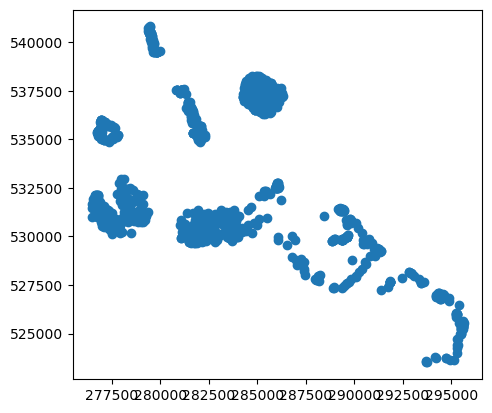

In [8]:
# open the smapling points
sampling_points = gpd.read_file(FLOOD_SAMPLING_PATH)
# view sampling points
sampling_points.plot()

In [9]:
# create a column for the point index
sampling_points['index_ID'] =sampling_points.index

Split the Image into a chip size of 128 by 128

In [10]:
MASK_FOLDER = os.path.join(DATA_DIR, "mask")
SQAURE_BOUND = os.path.join(MASK_FOLDER, "squares.shp")

In [11]:
# Define spatial resolution (meters per pixel)
resolution = 1

# Chip size in pixels
chip_size = 128

# Calculate buffer distance (half of chip size in meters)
buffer_dist = (chip_size * resolution) / 2

# Read in the shapefile (assuming 'sampling_points' is already a GeoDataFrame)
df_points = sampling_points.copy()

# Create square buffers (128 x 128 meters)
df_points['geometry'] = df_points.buffer(buffer_dist)

# Convert the circular buffer to a square envelope (bounding box)
df_points['geometry'] = df_points.geometry.envelope

# Save the new shapefile
df_points.to_file(SQAURE_BOUND)

In [12]:
os.getcwd()

'C:\\Users\\Admin\\Desktop\\geoai_flood_prediction\\notebooks'

In [13]:
# Read shapefile
df_points = gpd.read_file(SQAURE_BOUND )

# Create an output directory if it doesn't exist
INDIVIDUAL_FEATURES = os.path.join(DATA_DIR, "individual_features")
os.makedirs(INDIVIDUAL_FEATURES, exist_ok=True)

# Iterate over each feature in the shapefile
for index, feature in df_points.iterrows():
    # Create a new GeoDataFrame with just the current feature
    feature_gdf = df_points.loc[[index]]

    # Define the output filename
    output_file = os.path.join(INDIVIDUAL_FEATURES, f"feature_{index}.shp")

    # Save the feature to a new shapefile
    feature_gdf.to_file(output_file)

print("Shapefiles saved successfully!")

Shapefiles saved successfully!


In [14]:
len(df_points)

1150

### Create a composite raster bands

In [15]:
# Define the input directory
OUTPUT_FILE = os.path.join(INPUT_DIR, "composite_raster.tif")

# List all .tif files in the directory (excluding composite_raster.tif if it exists)
raster_files = [os.path.join(INPUT_DIR, file) for file in os.listdir(INPUT_DIR) 
                if file.endswith(".tif") and file != "composite_raster.tif"]

# Ensure there are rasters to process
if not raster_files:
    raise FileNotFoundError("No raster files found in the directory!")

# Open the first raster to get metadata
sample_ds = gdal.Open(raster_files[0])
cols = sample_ds.RasterXSize
rows = sample_ds.RasterYSize
proj = sample_ds.GetProjection()
gt = sample_ds.GetGeoTransform()

# Create an output raster with the same dimensions but multiple bands
driver = gdal.GetDriverByName("GTiff")
out_ds = driver.Create(OUTPUT_FILE, cols, rows, len(raster_files), gdal.GDT_Float32)

# Set projection and geotransform
out_ds.SetProjection(proj)
out_ds.SetGeoTransform(gt)

# Read and stack bands
for idx, raster in enumerate(raster_files):
    ds = gdal.Open(raster)

    # Check dimensions
    if ds.RasterXSize != cols or ds.RasterYSize != rows:
        print(f"Resampling {raster} to match dimensions {cols}x{rows}...")
        ds = gdal.Warp("", ds, width=cols, height=rows, format="VRT", resampleAlg=gdal.GRA_Bilinear)

    band = ds.GetRasterBand(1).ReadAsArray()
    out_ds.GetRasterBand(idx + 1).WriteArray(band)  # Write to corresponding band
    ds = None  # Close dataset

# Save and close
out_ds = None  # Closes the output raster file

print(f"Composite raster saved as: {OUTPUT_FILE}")

Resampling C:/Users/Admin/Desktop/geoai_flood_prediction\data/PH_METRO/TRAIN\input\blue.tif to match dimensions 19270x17546...
Resampling C:/Users/Admin/Desktop/geoai_flood_prediction\data/PH_METRO/TRAIN\input\curvature.tif to match dimensions 19270x17546...
Resampling C:/Users/Admin/Desktop/geoai_flood_prediction\data/PH_METRO/TRAIN\input\dsm.tif to match dimensions 19270x17546...
Resampling C:/Users/Admin/Desktop/geoai_flood_prediction\data/PH_METRO/TRAIN\input\dtm.tif to match dimensions 19270x17546...
Resampling C:/Users/Admin/Desktop/geoai_flood_prediction\data/PH_METRO/TRAIN\input\ele_diff.tif to match dimensions 19270x17546...
Resampling C:/Users/Admin/Desktop/geoai_flood_prediction\data/PH_METRO/TRAIN\input\green.tif to match dimensions 19270x17546...
Resampling C:/Users/Admin/Desktop/geoai_flood_prediction\data/PH_METRO/TRAIN\input\lulc.tif to match dimensions 19270x17546...
Resampling C:/Users/Admin/Desktop/geoai_flood_prediction\data/PH_METRO/TRAIN\input\openwater.tif to mat

### Open the predictive feaure raster and create images for each feature

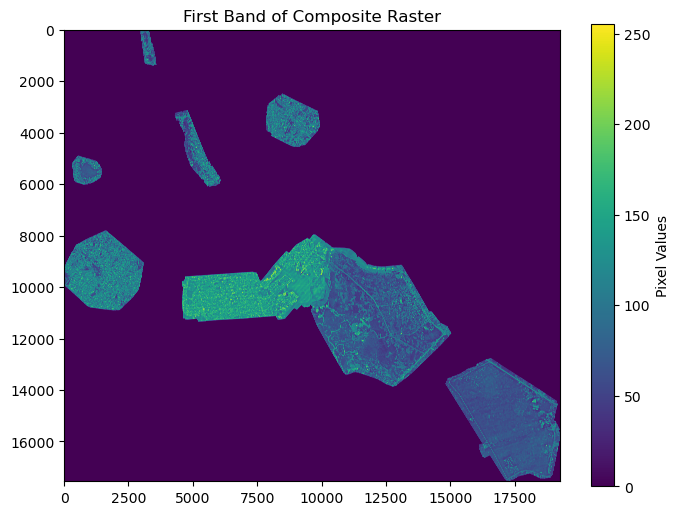

In [16]:
# Open the raster file
ds = gdal.Open(os.path.join(INPUT_DIR, "composite_raster.tif"))  # Open a multi-band raster of the predictive raster files
gt = ds.GetGeoTransform()  # Get transformation data
proj = ds.GetProjection()  # Get projection

# Read the first band
band = ds.GetRasterBand(2)
array = band.ReadAsArray()

# Plot the raster to check that everything is working
plt.figure(figsize=(8, 6))
plt.imshow(array, cmap="viridis")  # Apply a color map
plt.colorbar(label="Pixel Values")  # Add a color bar
plt.title("First Band of Composite Raster")
plt.show()

In [17]:
INDIVIDUAL_FEATURES

'C:/Users/Admin/Desktop/geoai_flood_prediction\\data/PH_METRO/TRAIN\\individual_features'

In [19]:
import glob

# Path to the folder where we saved the split polygons
os.chdir(INDIVIDUAL_FEATURES)

# Get all shapefiles in the folder
shp_files = glob.glob("*.shp")

# Create output directories if they don't exist
os.makedirs("NotFlooded", exist_ok=True)
os.makedirs("Flooded", exist_ok=True)

# Define your raster dataset (Make sure ds is properly defined)
ds = gdal.Open(os.path.join(INPUT_DIR, "composite_raster.tif"))  # Update with the actual path

for file in shp_files:
    ds2 = ogr.Open(file, 1)
    layer = ds2.GetLayer()
    shp_ds = gpd.read_file(file)

    # Ensure the shapefile is not empty before accessing its attributes
    if not shp_ds.empty:
        label = shp_ds.iloc[0]['Label']  # Safer way to access the label

        output_folder = "NotFlooded" if label == 0 else "Flooded"
        output_path = os.path.join(INDIVIDUAL_FEATURES,output_folder,f"feature_{file[:-4]}.tif")

        # Clip and save the raster
        gdal.Warp(output_path, ds, cutlineDSName=file, cropToCutline=True, dstNodata=np.nan)

print("Processing complete!")

Processing complete!


In [20]:
len(shp_files)

1150